In [1]:
import numpy as np
import ROOT as rt
import uproot

Welcome to JupyROOT 6.12/07


In [2]:
# Expecting 540629 qcdSigExt events
# qcdSigExt
h_t_bin_content = [201768.0, 120440.0, 73590.0, 47403.0, 30366.0, 20378.0, 13591.0, 
                   9490.0, 6295.0, 4591.0, 3336.0, 2332.0, 1740.0, 1354.0, 1004.0, 
                   710.0, 537.0, 401.0, 274.0, 243.0, 177.0, 148.0, 99.0, 77.0, 56.0, 
                   43.0, 39.0, 24.0, 22.0, 23.0]
h_a_bin_content = [1782.0, 1103.0, 786.0, 491.0, 291.0, 195.0, 120.0, 88.0, 53.0, 60.0, 
                   32.0, 24.0, 19.0, 11.0, 3.0, 4.0, 11.0, 3.0, 4.0, 6.0, 2.0, 5.0, 1.0, 
                   1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
h_r_bin_content = [199986.0, 119337.0, 72804.0, 46912.0, 30075.0, 20183.0, 13471.0, 9402.0, 
                   6242.0, 4531.0, 3304.0, 2308.0, 1721.0, 1343.0, 1001.0, 706.0, 526.0, 398.0, 
                   270.0, 237.0, 175.0, 143.0, 98.0, 76.0, 55.0, 42.0, 38.0, 24.0, 22.0, 23.0]

# xsec BSM = 1.00E+1
# Expecting 11281 GtoWW3 events
# GtoWW3
h_t_signal = [61.0, 66.0, 100.0, 126.0, 142.0, 213.0, 218.0, 294.0, 356.0, 398.0, 438.0, 438.0, 
              499.0, 548.0, 484.0, 504.0, 499.0, 524.0, 505.0, 510.0, 525.0, 629.0, 706.0, 764.0, 
              826.0, 563.0, 219.0, 49.0, 23.0, 14.0]
h_a_signal = [28.0, 35.0, 44.0, 63.0, 74.0, 109.0, 92.0, 109.0, 124.0, 128.0, 109.0, 86.0, 68.0, 
              53.0, 23.0, 24.0, 17.0, 10.0, 16.0, 9.0, 7.0, 10.0, 14.0, 15.0, 14.0, 11.0, 6.0, 2.0, 
              0.0, 0.0]
h_r_signal = [33.0, 31.0, 56.0, 63.0, 68.0, 104.0, 126.0, 185.0, 232.0, 270.0, 329.0, 352.0, 431.0, 
              495.0, 461.0, 480.0, 482.0, 514.0, 489.0, 501.0, 518.0, 619.0, 692.0, 749.0, 812.0, 
              552.0, 213.0, 47.0, 23.0, 14.0]

bin_edges = np.linspace(1100,4000,31)

n_bins = len(bin_edges)-1
max_bin = bin_edges[-1]
min_bin = bin_edges[0]

In [3]:
# prepare histograms and scale
background_hist_acc = rt.TH1D('background_acc','background_acc', n_bins, min_bin, max_bin)
signal_hist_acc = rt.TH1D('signal_acc','signal_acc', n_bins, min_bin, max_bin)
data_hist_acc = rt.TH1D('data_obs_acc','data_obs_acc', n_bins, min_bin, max_bin)

background_hist_rej = rt.TH1D('background_rej','background_rej', n_bins, min_bin, max_bin)
signal_hist_rej = rt.TH1D('signal_rej','signal_rej', n_bins, min_bin, max_bin)
data_hist_rej = rt.TH1D('data_obs_rej','data_obs_rej', n_bins, min_bin, max_bin)

for i, b in enumerate(h_a_bin_content):
    background_hist_acc.SetBinContent(i+1, b)
    data_hist_acc.SetBinContent(i+1, b)
for i, s in enumerate(h_a_signal):
    signal_hist_acc.SetBinContent(i+1, s)
    
for i, b in enumerate(h_r_bin_content):
    background_hist_rej.SetBinContent(i+1, b)
    data_hist_rej.SetBinContent(i+1, b)
for i, s in enumerate(h_r_signal):
    signal_hist_rej.SetBinContent(i+1, s)

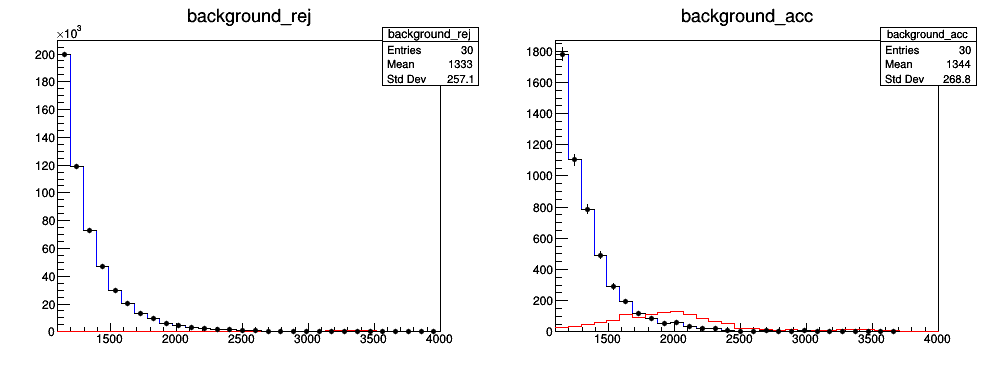

In [4]:
# plot background, signal, data
c = rt.TCanvas('c','c',1000,400)
c.Divide(2,1)

c.cd(1)
background_hist_rej.SetLineColor(rt.kBlue)
background_hist_rej.Draw('hist')
signal_hist_rej.SetLineColor(rt.kRed)
signal_hist_rej.Draw('histsame')
data_hist_rej.SetLineColor(rt.kBlack)
data_hist_rej.SetMarkerColor(rt.kBlack)
data_hist_rej.SetMarkerStyle(20)
data_hist_rej.SetMarkerSize(0.5)
data_hist_rej.Draw('pezsame')

c.cd(2)
background_hist_acc.SetLineColor(rt.kBlue)
background_hist_acc.Draw('hist')
signal_hist_acc.SetLineColor(rt.kRed)
signal_hist_acc.Draw('histsame')
data_hist_acc.SetLineColor(rt.kBlack)
data_hist_acc.SetMarkerColor(rt.kBlack)
data_hist_acc.SetMarkerStyle(20)
data_hist_acc.SetMarkerSize(0.5)
data_hist_acc.Draw('pezsame')

c.Draw()

In [5]:
# set up workspace

datacard_ws = rt.TFile.Open('datacard_ws.root','recreate')
w = rt.RooWorkspace('w','w')
x = rt.RooRealVar('x','x',min_bin,max_bin)
w.factory('x[%.1f,%.1f]'%(min_bin, max_bin))

acc_bin_functions = rt.RooArgList()
rej_bin_functions = rt.RooArgList()
w.factory('eff[%f,0,1]'%(background_hist_acc.Integral()/background_hist_rej.Integral()))
w.var('eff').setConstant(True)

empty_hist = rt.TH1D('empty_hist','empty_hist', n_bins, min_bin, max_bin)
for iBinX in range(1,n_bins+1):
    empty_hist.SetBinContent(iBinX,1)
    w.factory('crBin%i_In[%.1f]'%(iBinX,background_hist_rej.GetBinContent(iBinX)))
    w.factory('crBin%i[0,-100,100]'%(iBinX))
    w.var('crBin%i_In'%iBinX).setConstant(True)
    w.var('crBin%i'%iBinX).setConstant(False)
    w.factory("expr::crBin%iFunc('max(0,@0*pow(1.0+%f,@1))',crBin%i_In,crBin%i)"%(iBinX,1/rt.TMath.Sqrt(background_hist_rej.GetBinContent(iBinX)),iBinX,iBinX))
    w.factory("expr::bin%iFunc('max(0,@0*@1)',eff,crBin%iFunc)"%(iBinX,iBinX))
    rej_bin_functions.add(w.function('crBin%iFunc'%iBinX))
    acc_bin_functions.add(w.function('bin%iFunc'%iBinX))
    
qcd_rph_rej = rt.RooParametricHist('background_rej','background_acc',w.var('x'),rej_bin_functions,empty_hist)
qcd_rph_rej_norm = rt.RooAddition('background_rej_norm','background_rej_norm',rej_bin_functions)
qcd_rph_acc = rt.RooParametricHist('background_acc','background_acc',w.var('x'),acc_bin_functions,empty_hist)
qcd_rph_acc_norm = rt.RooAddition('background_acc_norm','background_acc_norm',acc_bin_functions)
getattr(w,'import')(qcd_rph_rej, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_rej_norm, rt.RooFit.RecycleConflictNodes())
getattr(w,'import')(qcd_rph_acc, rt.RooCmdArg())
getattr(w,'import')(qcd_rph_acc_norm, rt.RooFit.RecycleConflictNodes())

ds_signal_acc = rt.RooDataHist('signal_acc','signal_acc',rt.RooArgList(w.var('x')),signal_hist_acc)
ds_signal_rej = rt.RooDataHist('signal_rej','signal_rej',rt.RooArgList(w.var('x')),signal_hist_rej)
getattr(w,'import')(ds_signal_acc, rt.RooCmdArg())
getattr(w,'import')(ds_signal_rej, rt.RooCmdArg())

ds_data_acc = rt.RooDataHist('data_obs_acc','data_obs_acc',rt.RooArgList(w.var('x')),data_hist_acc)
ds_data_rej = rt.RooDataHist('data_obs_rej','data_obs_rej',rt.RooArgList(w.var('x')),data_hist_rej)
getattr(w,'import')(ds_data_acc, rt.RooCmdArg())
getattr(w,'import')(ds_data_rej, rt.RooCmdArg())

datacard_ws.cd()
w.Write()
datacard_ws.Close()

w.Print('v')

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooParametricHist::background_rej
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooFormulaVar::crBin1Func for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin1_In for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin1 for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooFormulaVar::crBin2Func for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVar::crBin2_In for import of RooAddition::background_rej_norm
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) using existing copy of RooRealVa

In [6]:
# datacard template
# no background normalization uncertainty

datacard_ratio = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         signal     background
process         0          1
rate            {SIGRATE}    {BKGRATE}
--------------------------------
lumi lnN 1.01 -
eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   flatParam
crBin28   flatParam
crBin29   flatParam
crBin30   flatParam
'''

In [7]:
# write datacard
datacard_ratio_acc = datacard_ratio.format(BIN='acc',
                          OBS=data_hist_acc.Integral(),
                          BKGRATE=1,
                          SIGRATE=signal_hist_acc.Integral())
print(datacard_ratio_acc)
with open('datacard_ratio_acc.txt','w') as f:
    f.write(datacard_ratio_acc)
    
    
datacard_ratio_rej = datacard_ratio.format(BIN='rej',
                          OBS=data_hist_rej.Integral(),
                          BKGRATE=1,
                          SIGRATE=signal_hist_rej.Integral())
print(datacard_ratio_rej)
with open('datacard_ratio_rej.txt','w') as f:
    f.write(datacard_ratio_rej)


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_ws.root w:$PROCESS_$CHANNEL w:$PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin acc
observation 5098.0
------------------------------
bin             acc      acc
process         signal     background
process         0          1
rate            1300.0    1
--------------------------------
lumi lnN 1.01 -
eff   flatParam
crBin1   flatParam
crBin2   flatParam
crBin3   flatParam
crBin4   flatParam
crBin5   flatParam
crBin6   flatParam
crBin7   flatParam
crBin8   flatParam
crBin9   flatParam
crBin10   flatParam
crBin11   flatParam
crBin12   flatParam
crBin13   flatParam
crBin14   flatParam
crBin15   flatParam
crBin16   flatParam
crBin17   flatParam
crBin18   flatParam
crBin19   flatParam
crBin20   flatParam
crBin21   flatParam
crBin22   flatParam
crBin23   flatParam
crBin24   flatParam
crBin25   flatParam
crBin26   flatParam
crBin27   flatParam
crBin28   flatParam
crBin29   flatParam
crBin30   flatParam


imax 1
jmax 1
kmax *
-----

In [8]:
!combineCards.py rej=datacard_ratio_rej.txt acc=datacard_ratio_acc.txt > datacard_ratio.txt

# get obseverved goodness of fit test statistic (signal strength = 0)
!combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt

# get expected goodness of fit test statistic distribution from frequentist toys
!combine -M GoodnessOfFit --algo saturated --fixedSignalStrength 0 -d datacard_ratio.txt -t 100 --toysFreq

 <<< Combine >>> 
Will use saturated models to compute goodness of fit for a binned likelihood
>>> method used is GoodnessOfFit
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func is duplicated
Object crBin24Func is duplicated
Object crBin25Func is duplicated
Object crBin2

RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 24.6556
Done in 0.00 min (cpu), 0.00 min (real)
Generate toy 23/100
RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 29.9831
Done in 0.00 min (cpu), 0.00 min (real)
Generate toy 24/100
RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 32.6416
Done in 0.00 min (cpu), 0.00 min (real)
Generate toy 25/100
RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 31.9116
Done in 0.00 min (cpu), 0.00 min (real)
Generate toy 26/100
RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 23.9872
Done in 0.00 min (cpu), 0.00 min (real)
Generate toy 27/100
RooSimultaneousOpt: number of channel ma


 --- GoodnessOfFit --- 
Best fit test statistic: 28.7791
Done in 0.00 min (cpu), 0.00 min (real)
Generate toy 66/100
RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 29.8489
Done in 0.00 min (cpu), 0.00 min (real)
Generate toy 67/100
RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 20.0117
Done in 0.00 min (cpu), 0.00 min (real)
Generate toy 68/100
RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 32.462
Done in 0.00 min (cpu), 0.00 min (real)
Generate toy 69/100
RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test statistic: 27.2922
Done in 0.00 min (cpu), 0.00 min (real)
Generate toy 70/100
RooSimultaneousOpt: number of channel masks must equal number of channels

 --- GoodnessOfFit --- 
Best fit test st

In [9]:
# open file
obs_gof_file = uproot.open('higgsCombineTest.GoodnessOfFit.mH120.root')
obs_gof = obs_gof_file['limit'].arrays('limit')['limit'][0]

exp_gof_file = uproot.open('higgsCombineTest.GoodnessOfFit.mH120.123456.root')
exp_gof = exp_gof_file['limit'].arrays('limit')['limit']

# # get p-value
n_extreme = len(exp_gof[exp_gof > obs_gof])
n_total = len(exp_gof)
pval = 1.*n_extreme/n_total
print 'p-value = %.2f'%pval

p-value = 0.01


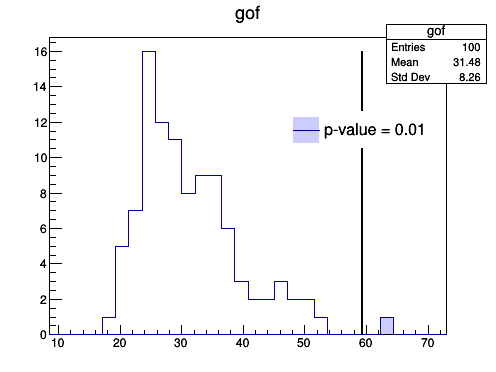

In [10]:
exp_gof_hist = rt.TH1D('gof','gof',30,min(exp_gof)-10, max(exp_gof)+10)
exp_gof_hist_gt = rt.TH1D('gof_gt','gof_gt',30,min(exp_gof)-10, max(exp_gof)+10)
for g in exp_gof: 
    exp_gof_hist.Fill(g)
    if g > obs_gof: 
        exp_gof_hist_gt.Fill(g)
d = rt.TCanvas('d','d',500,400)
tleg = rt.TLegend(0.58,0.6,0.88,0.7)
tleg.SetLineWidth(0)
exp_gof_hist.Draw('hist')
exp_gof_hist_gt.SetFillColor(rt.kBlue-10)
exp_gof_hist_gt.Draw('fhistsame')
line = rt.TLine(obs_gof,0,obs_gof,exp_gof_hist.GetMaximum())
line.SetLineWidth(2)
line.Draw()
tleg.AddEntry(exp_gof_hist_gt,'p-value = %.2f'%pval)
tleg.Draw()
d.Draw()

In [11]:
# get significance for a range of signal cross sections
import os

orig_xsec = 10.
xsec_to_scan = np.logspace(-4,0,10)

for mu in xsec_to_scan/orig_xsec:    
    os.environ['MU'] = str(mu)
    !combine -M Significance --setParameters r=${MU} -d datacard_ratio.txt -t -1 -n mu_${MU}

 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func is duplicated
Object crBin24Func is duplicated
Object crBin25Func is duplicated
Object crBin26Func is duplicated
Object crBin27Func is duplicated
Object crBin28Func is dup

Set Default Value of Parameter r To : 0.000215443

 -- Significance -- 
Significance: 0.00874865
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func is duplicated
Object crBin24Func i

Set Default Value of Parameter r To : 0.0129155

 -- Significance -- 
Significance: 0.638738
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func is duplicated
Object crBin24Func is du

In [12]:
# open file
for mu in xsec_to_scan/orig_xsec:    
    xsec = mu*orig_xsec
    signif_file = uproot.open('higgsCombinemu_%s.Significance.mH120.root'%str(mu))
    signif = signif_file['limit'].arrays('limit')['limit'][0]
    pval = rt.RooStats.SignificanceToPValue(signif)
    print('xsec', xsec, 'mu', mu, 'pval', pval, 'signif', signif)

('xsec', 0.0001, 'mu', 1e-05, 'pval', 0.5, 'signif', 0.0)
('xsec', 0.0002782559402207126, 'mu', 2.7825594022071256e-05, 'pval', 0.5, 'signif', 0.0)
('xsec', 0.000774263682681127, 'mu', 7.74263682681127e-05, 'pval', 0.5, 'signif', 0.0)
('xsec', 0.002154434690031882, 'mu', 0.0002154434690031882, 'pval', 0.49650983725510334, 'signif', 0.008748652220199582)
('xsec', 0.005994842503189409, 'mu', 0.0005994842503189409, 'pval', 0.48868605676915694, 'signif', 0.028363652619024182)
('xsec', 0.016681005372000592, 'mu', 0.0016681005372000592, 'pval', 0.4668083592913855, 'signif', 0.08329532362318469)
('xsec', 0.046415888336127774, 'mu', 0.004641588833612777, 'pval', 0.4083512056567598, 'signif', 0.23178834318751462)
('xsec', 0.12915496650148828, 'mu', 0.012915496650148827, 'pval', 0.26149654340481976, 'signif', 0.6387384625155118)
('xsec', 0.3593813663804626, 'mu', 0.03593813663804626, 'pval', 0.04144765215349881, 'signif', 1.7341283952814823)
('xsec', 1.0, 'mu', 0.1, 'pval', 2.1808004816063374e-0

In [13]:
# check just regular fit
!combine -M FitDiagnostics -d datacard_ratio.txt --plots -v 2


>>> method used is FitDiagnostics
>>> random number generator seed is 123456
Creating pdfs for individual modes (2): .    .   done.
Object crBin1Func is duplicated
Object crBin2Func is duplicated
Object crBin3Func is duplicated
Object crBin4Func is duplicated
Object crBin5Func is duplicated
Object crBin6Func is duplicated
Object crBin7Func is duplicated
Object crBin8Func is duplicated
Object crBin9Func is duplicated
Object crBin10Func is duplicated
Object crBin11Func is duplicated
Object crBin12Func is duplicated
Object crBin13Func is duplicated
Object crBin14Func is duplicated
Object crBin15Func is duplicated
Object crBin16Func is duplicated
Object crBin17Func is duplicated
Object crBin18Func is duplicated
Object crBin19Func is duplicated
Object crBin20Func is duplicated
Object crBin21Func is duplicated
Object crBin22Func is duplicated
Object crBin23Func is duplicated
Object crBin24Func is duplicated
Object crBin25Func is duplicated
Object crBin26Func is duplicated
Object crBin27Func

[utils::makePlots] Number of events for pdf in rej_x, pdf pdf_binrej__model_bonly_ = 535453
[utils::makePlots] Number of events for pdf in acc_x, pdf pdf_binacc__model_bonly_ = 5098.05
Error in <TList::Clear>: A list is accessing an object (0x7009ee4) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x700a18c) already deleted (list name = TList)
Info in <TCanvas::Print>: png file ./rej_x_fit_b.png has been created
Info in <TCanvas::Print>: png file ./rej_x_fit_b_logy.png has been created
Info in <TCanvas::Print>: png file ./acc_x_fit_b.png has been created
Info in <TCanvas::Print>: png file ./acc_x_fit_b_logy.png has been created
Info in <TCanvas::Print>: png file ./covariance_fit_b.png has been created

  RooFitResult: minimized FCN value: -4606.73, estimated distance to minimum: 8.04463e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Constant Parameter    Value

[utils::makePlots] Number of events for pdf in rej_x, pdf pdf_binrej = 535411
[utils::makePlots] Number of events for pdf in acc_x, pdf pdf_binacc = 5140.52
Error in <TList::Clear>: A list is accessing an object (0x700a434) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x700a6dc) already deleted (list name = TList)
Info in <TCanvas::Print>: png file ./rej_x_fit_s.png has been created
Info in <TCanvas::Print>: png file ./rej_x_fit_s_logy.png has been created
Info in <TCanvas::Print>: png file ./acc_x_fit_s.png has been created
Info in <TCanvas::Print>: png file ./acc_x_fit_s_logy.png has been created
Warning in <TFile::Append>: Replacing existing TH1: correlation_matrix (Potential memory leak).
Info in <TCanvas::Print>: png file ./covariance_fit_s.png has been created

 --- FitDiagnostics ---
Best fit r: 0.03557  -0.02049/+0.0210752  (68% CL)
Done in 0.08 min (cpu), 0.13 min (real)
Printing Message Summary From ... combine_logger.out
-------

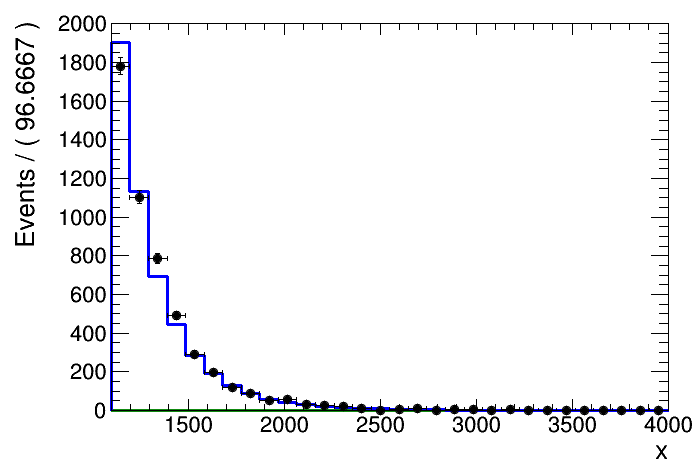

In [14]:
# accept region doesn't look great
from IPython.display import Image
Image(filename='acc_x_fit_b.png') 

# Without VAE

In [15]:
# prepare histograms and scale
background_hist_tot = rt.TH1D('background_tot','background_tot', n_bins, min_bin, max_bin)
signal_hist_tot = rt.TH1D('signal_tot','signal_tot', n_bins, min_bin, max_bin)
data_hist_tot = rt.TH1D('data_obs_tot','data_obs_tot', n_bins, min_bin, max_bin)

for i, b in enumerate(h_t_bin_content):
    background_hist_tot.SetBinContent(i+1, b)
    data_hist_tot.SetBinContent(i+1, b)
for i, s in enumerate(h_t_signal):
    signal_hist_tot.SetBinContent(i+1, s)
    

In [16]:
histos = {}
datacard_hist = rt.TFile.Open('datacard_hist.root','recreate')
datacard_hist.cd()
histos['signal_tot'] = signal_hist_tot
histos['qcd_tot'] = background_hist_tot
histos['data_obs_tot'] = data_hist_tot

histos['signal_acc'] = signal_hist_acc
histos['qcd_acc'] = background_hist_acc
histos['data_obs_acc'] = data_hist_acc
histos['signal_rej'] = signal_hist_rej
histos['qcd_rej'] = background_hist_rej
histos['data_obs_rej'] = data_hist_rej

for key, histo in histos.iteritems():
    datacard_hist.cd()
    histo.Write(key)
    if 'qcd' not in key:
        ds = rt.RooDataHist(key,key,rt.RooArgList(w.var('x')),histo)
        getattr(w,'import')(ds, rt.RooCmdArg())
datacard_hist.Close()

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(signal_rej): fit range of variable x expanded to nearest bin boundaries: [1100,4000] --> [1100,4000]
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset signal_rej
[#0] ERROR:ObjectHandling -- RooWorkspace::import(w) ERROR dataset with name signal_rej already exists in workspace, import aborted
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(data_obs_rej): fit range of variable x expanded to nearest bin boundaries: [1100,4000] --> [1100,4000]
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset data_obs_rej
[#0] ERROR:ObjectHandling -- RooWorkspace::import(w) ERROR dataset with name data_obs_rej already exists in workspace, import aborted
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(data_obs_tot): fit range of variable x expanded to nearest bin boundaries: [1100,4000] --> [1100,4000]
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset data_obs_tot
[#1] INFO:DataHandlin

In [17]:
datacard = \
'''
imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin {BIN}
observation {OBS}
------------------------------
bin             {BIN}      {BIN}
process         {BSM}     qcd
process         0          1
rate            {BSMRATE}    {QCDRATE}
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1
'''

datacard_tot = datacard.format(BIN='tot',
                          OBS=data_hist_tot.Integral(),
                          QCDRATE=background_hist_tot.Integral(),
                          BSM='signal',
                          BSMRATE=signal_hist_tot.Integral())
print(datacard_tot)
with open('datacard_tot.txt','w') as f:
    f.write(datacard_tot)
    
    
datacard_acc = datacard.format(BIN='acc',
                          OBS=data_hist_acc.Integral(),
                          QCDRATE=background_hist_acc.Integral(),
                          BSM='signal',
                          BSMRATE=signal_hist_acc.Integral())
print(datacard_acc)

with open('datacard_acc.txt','w') as f:
    f.write(datacard_acc)
    
datacard_rej = datacard.format(BIN='rej',
                          OBS=data_hist_rej.Integral(),
                          QCDRATE=background_hist_rej.Integral(),
                          BSM='signal',
                          BSMRATE=signal_hist_rej.Integral())
print(datacard_rej)
with open('datacard_rej.txt','w') as f:
    f.write(datacard_rej)
    


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin tot
observation 540551.0
------------------------------
bin             tot      tot
process         signal     qcd
process         0          1
rate            11241.0    540551.0
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin acc
observation 5098.0
------------------------------
bin             acc      acc
process         signal     qcd
process         0          1
rate            1300.0    5098.0
--------------------------------
lumi     lnN    1.10       1.10
bgnorm   lnN    1.00       1.30
* autoMCStats 0 0 1


imax 1
jmax 1
kmax *
---------------
shapes * * datacard_hist.root $PROCESS_$CHANNEL $PROCESS_$CHANNEL_$SYSTEMATIC
---------------
bin

In [18]:
import os

orig_xsec = 10.
xsec_to_scan = np.logspace(-4,0,10)

for mu in xsec_to_scan/orig_xsec:    
    os.environ['MU'] = str(mu)
    !combine -M Significance --setParameters r=${MU} -d datacard_tot.txt -t -1 -n tot_mu_${MU}

 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201829.000000   449.253826      total sum                     
0          201768.000000   449.185930      excluding marked processes    
0          201768.000000   449.185930      Unweighted events, alpha=1.000302
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120506.000000   347.139741      total sum                     
1          120440.000000   347.044666      excluding marked processes    
1          120440.000000   347.044666      Unweighted events, alpha=1.000548
  => Total parameter prop_bintot_bin1[0.00,-7.00,7

Set Default Value of Parameter r To : 1e-05

 -- Significance -- 
Significance: 0
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201829.000000   449.253826      total sum                     
0          201768.000000   449.185930      excluding marked processes    
0          201768.000000   449.185930      Unweighted events, alpha=1.000302
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120506.000000   347.139741      total sum                     
1          120440.000000   347.044666      excluding marked processes    
1    

Set Default Value of Parameter r To : 2.78256e-05

 -- Significance -- 
Significance: 0
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201829.000000   449.253826      total sum                     
0          201768.000000   449.185930      excluding marked processes    
0          201768.000000   449.185930      Unweighted events, alpha=1.000302
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120506.000000   347.139741      total sum                     
1          120440.000000   347.044666      excluding marked processes    

------------------------------------------------------------
26         258.000000      16.062378       total sum                     
26         39.000000       6.244998        excluding marked processes    
26         39.000000       6.244998        Unweighted events, alpha=6.615385
  => Total parameter prop_bintot_bin26[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
27         73.000000       8.544004        total sum                     
27         24.000000       4.898979        excluding marked processes    
27         24.000000       4.898979        Unweighted events, alpha=3.041667
  => Total parameter prop_bintot_bin27[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
28         45.000000       6.708204        total sum                     
28         22.000000       4.690416        excluding marked processes    
28         22.000000       4.690416        Unweighted

Set Default Value of Parameter r To : 0.000215443

 -- Significance -- 
Significance: 0.0286188
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201829.000000   449.253826      total sum                     
0          201768.000000   449.185930      excluding marked processes    
0          201768.000000   449.185930      Unweighted events, alpha=1.000302
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120506.000000   347.139741      total sum                     
1          120440.000000   347.044666      excluding marked proce

Set Default Value of Parameter r To : 0.000599484

 -- Significance -- 
Significance: 0.0861388
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201829.000000   449.253826      total sum                     
0          201768.000000   449.185930      excluding marked processes    
0          201768.000000   449.185930      Unweighted events, alpha=1.000302
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120506.000000   347.139741      total sum                     
1          120440.000000   347.044666      excluding marked proce

Set Default Value of Parameter r To : 0.0016681

 -- Significance -- 
Significance: 0.240651
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201829.000000   449.253826      total sum                     
0          201768.000000   449.185930      excluding marked processes    
0          201768.000000   449.185930      Unweighted events, alpha=1.000302
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120506.000000   347.139741      total sum                     
1          120440.000000   347.044666      excluding marked processe

Set Default Value of Parameter r To : 0.00464159

 -- Significance -- 
Significance: 0.666347
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201829.000000   449.253826      total sum                     
0          201768.000000   449.185930      excluding marked processes    
0          201768.000000   449.185930      Unweighted events, alpha=1.000302
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120506.000000   347.139741      total sum                     
1          120440.000000   347.044666      excluding marked process

Set Default Value of Parameter r To : 0.0129155

 -- Significance -- 
Significance: 1.83049
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201829.000000   449.253826      total sum                     
0          201768.000000   449.185930      excluding marked processes    
0          201768.000000   449.185930      Unweighted events, alpha=1.000302
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120506.000000   347.139741      total sum                     
1          120440.000000   347.044666      excluding marked processes

Set Default Value of Parameter r To : 0.0359381

 -- Significance -- 
Significance: 4.93391
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel tot will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bintot
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          201829.000000   449.253826      total sum                     
0          201768.000000   449.185930      excluding marked processes    
0          201768.000000   449.185930      Unweighted events, alpha=1.000302
  => Total parameter prop_bintot_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          120506.000000   347.139741      total sum                     
1          120440.000000   347.044666      excluding marked processes

Set Default Value of Parameter r To : 0.1

 -- Significance -- 
Significance: 12.8054
Done in 0.00 min (cpu), 0.00 min (real)


In [19]:
# open file
for mu in xsec_to_scan/orig_xsec:    
    xsec = mu*orig_xsec
    signif_file = uproot.open('higgsCombinetot_mu_%s.Significance.mH120.root'%str(mu))
    signif = signif_file['limit'].arrays('limit')['limit'][0]
    pval = rt.RooStats.SignificanceToPValue(signif)
    print('xsec', xsec, 'mu', mu, 'pval', pval, 'signif', signif)

('xsec', 0.0001, 'mu', 1e-05, 'pval', 0.5, 'signif', 0.0)
('xsec', 0.0002782559402207126, 'mu', 2.7825594022071256e-05, 'pval', 0.5, 'signif', 0.0)
('xsec', 0.000774263682681127, 'mu', 7.74263682681127e-05, 'pval', 0.49728798251438977, 'signif', 0.006798072071133514)
('xsec', 0.002154434690031882, 'mu', 0.0002154434690031882, 'pval', 0.4885843094302728, 'signif', 0.028618798912713052)
('xsec', 0.005994842503189409, 'mu', 0.0005994842503189409, 'pval', 0.4656780262753504, 'signif', 0.0861388348989434)
('xsec', 0.016681005372000592, 'mu', 0.0016681005372000592, 'pval', 0.40491296170278657, 'signif', 0.2406506075726892)
('xsec', 0.046415888336127774, 'mu', 0.004641588833612777, 'pval', 0.25259468633155513, 'signif', 0.6663469341961784)
('xsec', 0.12915496650148828, 'mu', 0.012915496650148827, 'pval', 0.033588232665346926, 'signif', 1.8304915757582538)
('xsec', 0.3593813663804626, 'mu', 0.03593813663804626, 'pval', 4.029978019791831e-07, 'signif', 4.933910072311294)
('xsec', 1.0, 'mu', 0.1

In [20]:
import os
!combineCards.py acc=datacard_acc.txt rej=datacard_rej.txt > datacard_comb.txt

orig_xsec = 10.
xsec_to_scan = np.logspace(-4,0,10)

for mu in xsec_to_scan/orig_xsec:    
    os.environ['MU'] = str(mu)
    !combine -M Significance --setParameters r=${MU} -d datacard_comb.txt -t -1 -n comb_mu_${MU}

 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          1810.000000     42.544095       total sum                     
0          1782.000000     42.213742       excluding marked processes    
0          1782.000000     42.213742       Unweighted events, alpha=1.015713
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          1138.000000     33.734256       total sum                     
1          1103.000000     33.211444       excluding marked processes    
1          1103.000000     33.211444       Unweighted events, alpha=1.031732
  => Total parameter prop_binacc_bin1[0.00,-7.00,7

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          200019.000000   447.234838      total sum                     
0          199986.000000   447.197943      excluding marked processes    
0          199986.000000   447.197943      Unweighted events, alpha=1.000165
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          119368.000000   345.496744      total sum                     
1          119337.000000   345.451878      excluding marked processes    
1          119337.000000   345.451878      Unweighted events, alpha=1.000260
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 1e-05

 -- Significance -- 
Significance: 0.0171871
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          1810.000000     42.544095       total sum                     
0          1782.000000     42.213742       excluding marked processes    
0          1782.000000     42.213742       Unweighted events, alpha=1.015713
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          1138.000000     33.734256       total sum                     
1          1103.000000     33.211444       excluding marked processes  

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          200019.000000   447.234838      total sum                     
0          199986.000000   447.197943      excluding marked processes    
0          199986.000000   447.197943      Unweighted events, alpha=1.000165
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          119368.000000   345.496744      total sum                     
1          119337.000000   345.451878      excluding marked processes    
1          119337.000000   345.451878      Unweighted events, alpha=1.000260
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 2.78256e-05

 -- Significance -- 
Significance: 0.0302603
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          1810.000000     42.544095       total sum                     
0          1782.000000     42.213742       excluding marked processes    
0          1782.000000     42.213742       Unweighted events, alpha=1.015713
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          1138.000000     33.734256       total sum                     
1          1103.000000     33.211444       excluding marked proce

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          200019.000000   447.234838      total sum                     
0          199986.000000   447.197943      excluding marked processes    
0          199986.000000   447.197943      Unweighted events, alpha=1.000165
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          119368.000000   345.496744      total sum                     
1          119337.000000   345.451878      excluding marked processes    
1          119337.000000   345.451878      Unweighted events, alpha=1.000260
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 7.74264e-05

 -- Significance -- 
Significance: 0.0589332
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          1810.000000     42.544095       total sum                     
0          1782.000000     42.213742       excluding marked processes    
0          1782.000000     42.213742       Unweighted events, alpha=1.015713
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          1138.000000     33.734256       total sum                     
1          1103.000000     33.211444       excluding marked proce

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          200019.000000   447.234838      total sum                     
0          199986.000000   447.197943      excluding marked processes    
0          199986.000000   447.197943      Unweighted events, alpha=1.000165
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          119368.000000   345.496744      total sum                     
1          119337.000000   345.451878      excluding marked processes    
1          119337.000000   345.451878      Unweighted events, alpha=1.000260
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.000215443

 -- Significance -- 
Significance: 0.106314
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          1810.000000     42.544095       total sum                     
0          1782.000000     42.213742       excluding marked processes    
0          1782.000000     42.213742       Unweighted events, alpha=1.015713
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          1138.000000     33.734256       total sum                     
1          1103.000000     33.211444       excluding marked proces

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          200019.000000   447.234838      total sum                     
0          199986.000000   447.197943      excluding marked processes    
0          199986.000000   447.197943      Unweighted events, alpha=1.000165
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          119368.000000   345.496744      total sum                     
1          119337.000000   345.451878      excluding marked processes    
1          119337.000000   345.451878      Unweighted events, alpha=1.000260
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.000599484

 -- Significance -- 
Significance: 0.197652
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          1810.000000     42.544095       total sum                     
0          1782.000000     42.213742       excluding marked processes    
0          1782.000000     42.213742       Unweighted events, alpha=1.015713
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          1138.000000     33.734256       total sum                     
1          1103.000000     33.211444       excluding marked proces

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          200019.000000   447.234838      total sum                     
0          199986.000000   447.197943      excluding marked processes    
0          199986.000000   447.197943      Unweighted events, alpha=1.000165
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          119368.000000   345.496744      total sum                     
1          119337.000000   345.451878      excluding marked processes    
1          119337.000000   345.451878      Unweighted events, alpha=1.000260
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.0016681

 -- Significance -- 
Significance: 0.393081
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          1810.000000     42.544095       total sum                     
0          1782.000000     42.213742       excluding marked processes    
0          1782.000000     42.213742       Unweighted events, alpha=1.015713
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          1138.000000     33.734256       total sum                     
1          1103.000000     33.211444       excluding marked processe

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          200019.000000   447.234838      total sum                     
0          199986.000000   447.197943      excluding marked processes    
0          199986.000000   447.197943      Unweighted events, alpha=1.000165
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          119368.000000   345.496744      total sum                     
1          119337.000000   345.451878      excluding marked processes    
1          119337.000000   345.451878      Unweighted events, alpha=1.000260
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.00464159

 -- Significance -- 
Significance: 0.864633
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          1810.000000     42.544095       total sum                     
0          1782.000000     42.213742       excluding marked processes    
0          1782.000000     42.213742       Unweighted events, alpha=1.015713
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          1138.000000     33.734256       total sum                     
1          1103.000000     33.211444       excluding marked process

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          200019.000000   447.234838      total sum                     
0          199986.000000   447.197943      excluding marked processes    
0          199986.000000   447.197943      Unweighted events, alpha=1.000165
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          119368.000000   345.496744      total sum                     
1          119337.000000   345.451878      excluding marked processes    
1          119337.000000   345.451878      Unweighted events, alpha=1.000260
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.0129155

 -- Significance -- 
Significance: 2.0897
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          1810.000000     42.544095       total sum                     
0          1782.000000     42.213742       excluding marked processes    
0          1782.000000     42.213742       Unweighted events, alpha=1.015713
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          1138.000000     33.734256       total sum                     
1          1103.000000     33.211444       excluding marked processes 

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          200019.000000   447.234838      total sum                     
0          199986.000000   447.197943      excluding marked processes    
0          199986.000000   447.197943      Unweighted events, alpha=1.000165
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          119368.000000   345.496744      total sum                     
1          119337.000000   345.451878      excluding marked processes    
1          119337.000000   345.451878      Unweighted events, alpha=1.000260
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.0359381

 -- Significance -- 
Significance: 5.30969
Done in 0.00 min (cpu), 0.00 min (real)
 <<< Combine >>> 
>>> method used is Significance
>>> random number generator seed is 123456
Channel acc will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binacc
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          1810.000000     42.544095       total sum                     
0          1782.000000     42.213742       excluding marked processes    
0          1782.000000     42.213742       Unweighted events, alpha=1.015713
  => Total parameter prop_binacc_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          1138.000000     33.734256       total sum                     
1          1103.000000     33.211444       excluding marked processes

Channel rej will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_binrej
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          200019.000000   447.234838      total sum                     
0          199986.000000   447.197943      excluding marked processes    
0          199986.000000   447.197943      Unweighted events, alpha=1.000165
  => Total parameter prop_binrej_bin0[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
1          119368.000000   345.496744      total sum                     
1          119337.000000   345.451878      excluding marked processes    
1          119337.000000   345.451878      Unweighted events, alpha=1.000260
  => Total parameter prop_binrej_bin1[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------


Set Default Value of Parameter r To : 0.1

 -- Significance -- 
Significance: 13.461
Done in 0.00 min (cpu), 0.00 min (real)


In [21]:
# open file
for mu in xsec_to_scan/orig_xsec:    
    xsec = mu*orig_xsec
    signif_file = uproot.open('higgsCombinecomb_mu_%s.Significance.mH120.root'%str(mu))
    signif = signif_file['limit'].arrays('limit')['limit'][0]
    pval = rt.RooStats.SignificanceToPValue(signif)
    print('xsec', xsec, 'mu', mu, 'pval', pval, 'signif', signif)

('xsec', 0.0001, 'mu', 1e-05, 'pval', 0.49314366754338623, 'signif', 0.017187122929842244)
('xsec', 0.0002782559402207126, 'mu', 2.7825594022071256e-05, 'pval', 0.4879297488008313, 'signif', 0.030260250435080592)
('xsec', 0.000774263682681127, 'mu', 7.74263682681127e-05, 'pval', 0.47650267534452045, 'signif', 0.05893315421487864)
('xsec', 0.002154434690031882, 'mu', 0.0002154434690031882, 'pval', 0.45766656519007093, 'signif', 0.10631411818757425)
('xsec', 0.005994842503189409, 'mu', 0.0005994842503189409, 'pval', 0.42165880563022273, 'signif', 0.19765166247537874)
('xsec', 0.016681005372000592, 'mu', 0.0016681005372000592, 'pval', 0.3471298567470423, 'signif', 0.3930809231833161)
('xsec', 0.046415888336127774, 'mu', 0.004641588833612777, 'pval', 0.1936201251453693, 'signif', 0.8646330067479148)
('xsec', 0.12915496650148828, 'mu', 0.012915496650148827, 'pval', 0.018322299752937216, 'signif', 2.089701752343729)
('xsec', 0.3593813663804626, 'mu', 0.03593813663804626, 'pval', 5.4907213712